<a href="https://colab.research.google.com/github/jijan67/Sentiment-Analysis-CNN-LSTM-Ensemble/blob/main/Ensemble_Model_for_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization, LSTM, Input, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load the data
df_train = pd.read_csv("/content/drive/MyDrive/Sentiment analysis/twitter_training.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Sentiment analysis/twitter_validation.csv")


In [ ]:
# Rename columns
df_train.columns = ['Header1', 'company', 'labels', 'text']
df_test.columns = ['Header1', 'company', 'labels', 'text']


In [ ]:
# Drop unnecessary columns
df_train.drop(columns=['Header1', 'company'], inplace=True)
df_test.drop(columns=['Header1', 'company'], inplace=True)


In [ ]:
# Function to clean tweets
def clean_tweet(tweet):
    if not isinstance(tweet, str):
        return ""
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    tweet = re.sub(r'\W', ' ', tweet)
    tweet = re.sub(r'\d', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet = tweet.strip()
    return tweet

In [ ]:
# Clean and preprocess the data
df_train['text'] = df_train['text'].apply(clean_tweet).str.lower()
df_test['text'] = df_test['text'].apply(clean_tweet).str.lower()


In [ ]:
# Remove empty or whitespace-only texts
df_train = df_train[df_train['text'].str.strip() != '']
df_test = df_test[df_test['text'].str.strip() != '']


In [ ]:
# Remove duplicates
df_train = df_train.drop_duplicates(subset=['text'])


In [ ]:
# Separate features and labels
train_texts = df_train['text'].values
train_labels = df_train['labels'].values
test_texts = df_test['text'].values
test_labels = df_test['labels'].values


In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)


In [ ]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
tokenizer.fit_on_texts(test_texts)


In [ ]:
# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)


In [ ]:
# Pad the sequences
maxlen = max(len(tokens) for tokens in train_sequences)
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')


In [ ]:
# Get input size for the embedding layer
input_size = np.max(train_padded) + 1


In [ ]:
# CNN Model
cnn_input = Input(shape=(maxlen,))
cnn_embedding = Embedding(input_dim=input_size, output_dim=100)(cnn_input)
cnn_conv = Conv1D(128, kernel_size=5, activation='relu')(cnn_embedding)
cnn_pool = GlobalMaxPooling1D()(cnn_conv)
cnn_output = Dense(64, activation='relu')(cnn_pool)
cnn_output = Dropout(0.5)(cnn_output)

In [ ]:
# LSTM Model
lstm_input = Input(shape=(maxlen,))
lstm_embedding = Embedding(input_dim=input_size, output_dim=100)(lstm_input)
lstm_layer = LSTM(128, return_sequences=True)(lstm_embedding)
lstm_output = GlobalMaxPooling1D()(lstm_layer)
lstm_output = Dense(64, activation='relu')(lstm_output)
lstm_output = Dropout(0.5)(lstm_output)


In [ ]:
# Combine CNN and LSTM outputs
combined = concatenate([cnn_output, lstm_output])
ensemble_output = Dense(64, activation='relu')(combined)
ensemble_output = Dropout(0.5)(ensemble_output)
ensemble_output = Dense(len(label_encoder.classes_), activation='softmax')(ensemble_output)


In [ ]:
# Define the ensemble model
ensemble_model = Model(inputs=[cnn_input, lstm_input], outputs=ensemble_output)
ensemble_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the ensemble model
ensemble_history = ensemble_model.fit(
    [train_padded, train_padded], train_labels_encoded,
    validation_data=([test_padded, test_padded], test_labels_encoded),
    epochs=10
)


Epoch 1/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - accuracy: 0.5091 - loss: 1.1081 - val_accuracy: 0.9129 - val_loss: 0.2702
Epoch 2/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 75s 17ms/step - accuracy: 0.8949 - loss: 0.3183 - val_accuracy: 0.9580 - val_loss: 0.1634
Epoch 3/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9563 - loss: 0.1378 - val_accuracy: 0.9580 - val_loss: 0.1745
Epoch 4/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9721 - loss: 0.0880 - val_accuracy: 0.9580 - val_loss: 0.1735
Epoch 5/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.9798 - loss: 0.0614 - val_accuracy: 0.9540 - val_loss: 0.2537
Epoch 6/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.9837 - loss: 0.0539 - val_accuracy: 0.9580 - val_loss: 0.2681
Epoch 7/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9870 - loss: 0.0412 - val_accuracy: 0.9620 - val_loss: 0.2193
Epoch 8/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.9872 -

In [ ]:
# Evaluate the ensemble model
ensemble_test_loss, ensemble_test_accuracy = ensemble_model.evaluate([test_padded, test_padded], test_labels_encoded)
print(f'Ensemble Test Loss: {ensemble_test_loss}')
print(f'Ensemble Test Accuracy: {ensemble_test_accuracy}')


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9650 - loss: 0.1883
Ensemble Test Loss: 0.2989938259124756
Ensemble Test Accuracy: 0.9589589834213257


In [ ]:
# Generate predictions for test data
ensemble_predictions = ensemble_model.predict([test_padded, test_padded])
ensemble_predicted_labels = np.argmax(ensemble_predictions, axis=1)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
# Classification report
print("\nEnsemble Model Classification Report:\n")
print(classification_report(test_labels_encoded, ensemble_predicted_labels, target_names=label_encoder.classes_))



Ensemble Model Classification Report:

              precision    recall  f1-score   support

  Irrelevant       0.94      0.98      0.96       171
    Negative       0.97      0.96      0.96       266
     Neutral       0.97      0.94      0.96       285
    Positive       0.95      0.97      0.96       277

    accuracy                           0.96       999
   macro avg       0.96      0.96      0.96       999
weighted avg       0.96      0.96      0.96       999



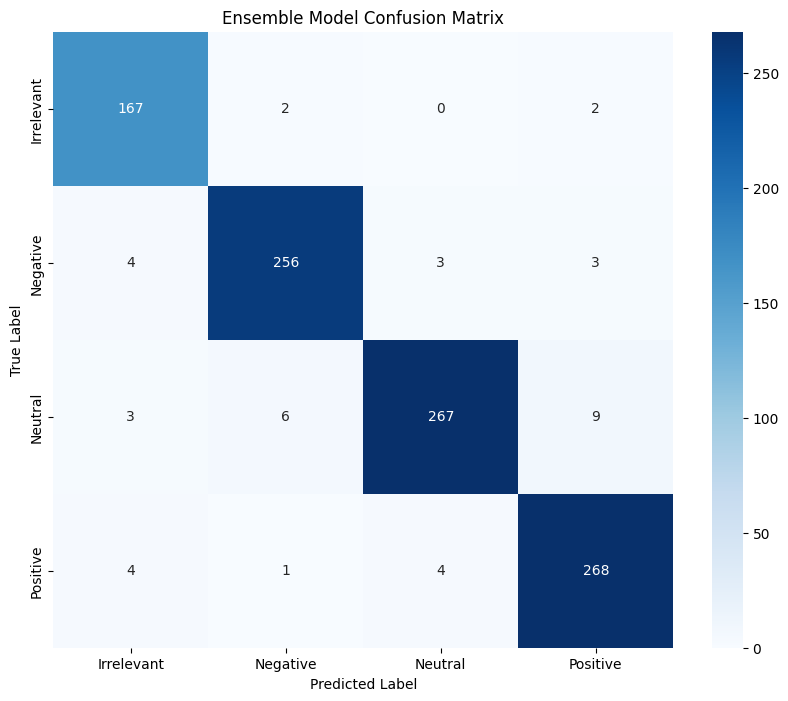

In [ ]:
# Confusion matrix
ensemble_conf_matrix = confusion_matrix(test_labels_encoded, ensemble_predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(ensemble_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Ensemble Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

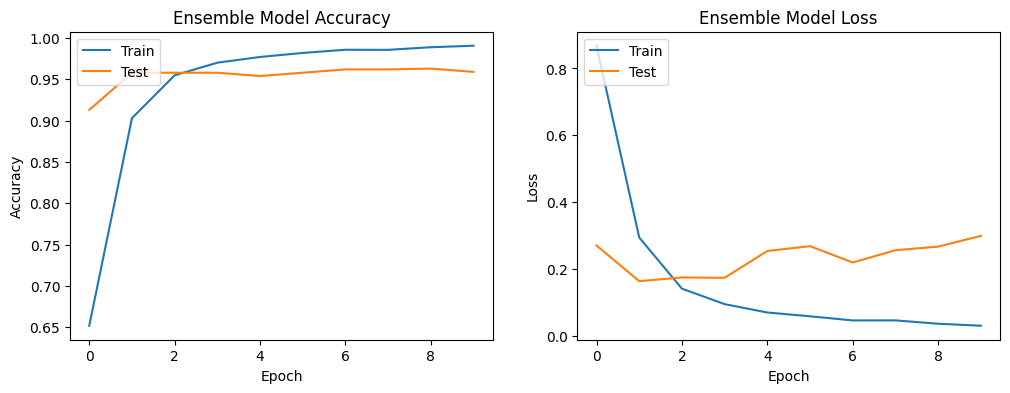

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(ensemble_history.history['accuracy'])
plt.plot(ensemble_history.history['val_accuracy'])
plt.title('Ensemble Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(ensemble_history.history['loss'])
plt.plot(ensemble_history.history['val_loss'])
plt.title('Ensemble Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Function for predicting new text using ensemble model
def predict_text_ensemble(text, model, tokenizer, label_encoder, maxlen):
    cleaned_text = clean_tweet(text).lower()
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=maxlen, padding='post')
    prediction = model.predict([padded_sequence, padded_sequence])
    predicted_label = np.argmax(prediction, axis=1)
    label_name = label_encoder.inverse_transform(predicted_label)
    return label_name[0]

# Test the prediction function with a new text
sample_text = "I love You"
predicted_label = predict_text_ensemble(sample_text, ensemble_model, tokenizer, label_encoder, maxlen)
print("Predicted Sentiment/Label for sample text:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Predicted Sentiment/Label for sample text: Positive
